![banner](https://github.com/priyammaz/PyTorch-Adventures/blob/main/src/visuals/banner.png?raw=true)

# DeepSpeech2: Intro to ASR


<img src="https://github.com/priyammaz/PyTorch-Adventures/blob/main/src/visuals/deepspeech2.png?raw=true" alt="drawing" width="500"/>

Automatic speech recognition is a core technology in a lot of applications today, especially when it comes to accessibility. Having a device understand your voice commands (like Siri or Alexa) is just another step towards integrating technology into everday life. Today we will be building the DeepSpeech2 model, and early Convolution + RNN based model that leverages the CTC loss for voice to text transcriptions. This will set a baseline for how ASR models are typically built!

In [1]:
import os
import numpy as np
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
import torchaudio
import torchaudio.transforms as T
import torchaudio.functional as F
import matplotlib.pyplot as plt
from transformers import Wav2Vec2CTCTokenizer, get_cosine_schedule_with_warmup
from jiwer import wer


### Tokenizer

Most ASR models are basically Character Level Models. This means we want to predict what letter goes where, and the models goal is to spell out the sounds from the audio! We could easily make this, as our CTC loss needs the characters ```A - Z``` and then the special ```blank``` token. If you want to learn more about CTC Here are a few resources:

- [My CTC Implementation](https://github.com/priyammaz/PyTorch-Adventures/tree/main/PyTorch%20for%20Audio/Connectionist%20Temporal%20Classification) which was greatly inspired by [repo](https://github.com/vadimkantorov/ctc/tree/master) by [vadimkantorov](https://github.com/vadimkantorov)
- Great [article](https://distill.pub/2017/ctc/) by Awni Hannun

Now we could easily make a tokenizer with a dictionary like this:

```python
{
    "<BLANK>": 0, 
     "A": 1, 
     "B": 2, 
     ...
}
```

And then we could write a CTC decoder (which basically just collapses repeating characters and removes blank kind of like this:

- GGG_OO_O_DDD -> GOOD

But to keep it simple we will just use an existing tokenizer from Huggingface. We could really pick any ASR tokenizer as they are all mostly the same, so we are just using the one from [Wav2Vec2](https://arxiv.org/abs/2006.11477). This simplifies our code as this tokenizer has the CTC decoder built right in, and also we are building upto implementing Wav2Vec2 so you get a little familiarity with one of the tools we will use! 

In [2]:
tokenizer = Wav2Vec2CTCTokenizer.from_pretrained("facebook/wav2vec2-base")

/home/priyam/anaconda3/envs/torch/lib/python3.12/site-packages/transformers/configuration_utils.py:311: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


### Librispeech Dataset

The [Librispeech Dataset](https://www.openslr.org/12) is one of the most popular ASR datasets out there. An ASR dataset has to always have two things, an Audio file and its corresponding Transcript. Our goal is to train a Neural Network that can take the audio and predict the transcript. The Librispeech dataset has a bunch of splits:

- train-clean-100
- train-clean-360
- train-other-500
- test-clean
- dev-clean

This is about 1000 Hours of training data (500 of it being clean and the other 500 maybe having lower audio quality or noise). If you are looking at this notebook in Google Colab, we will just train on the ```train-clean-100``` split due to compute limitations, but in the full notebook in GitHub ill go ahead and train on all of it! 

### What This Dataset Needs

#### Paths to Samples 
This is a pretty simple dataset to write. We will create a list of tuples that have the path to the audio file and their cooresponding transcript stored in memory 

#### Conversion to Mel Spectrograms
We will be implementing DeepSpeech2 today which takes Mel Spectrograms. If you want to learn more about spectrograms you can see it here:

- [Introduction to Audio Processing](https://github.com/priyammaz/PyTorch-Adventures/tree/main/PyTorch%20for%20Audio/Intro%20to%20Audio%20Processing)

The Mel Spectrogram is a better indiciator of human auditory perception rather than just raw frequency values as you would get from a typical fourier transform, so thats what DeepSpeech2 (and many other architectures) use. Another option would have been to train directly on the waveforms (as Wav2Vec2 does), but lets keep close to DeepSpeech2 for now! DeepSpeech2 uses 80 Mel bins in their implementation, so we will do the same!

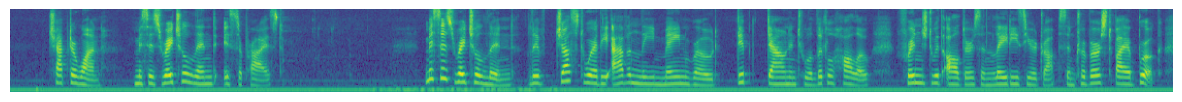

In [3]:
class LibriSpeechDataset(Dataset):

    """
    LibriSpeechDataset downloaded from OpenSLR: https://www.openslr.org/12

    There are 5 splits downloaded, 3 which are for training and 3 for testing:

        Training: ["train-clean-100", "train-clean-360", "train-other-500"]
        Validation: ["dev-clean", "test-clean"]

    """
    def __init__(self, 
                 path_to_data_root, 
                 include_splits=["train-clean-100", "train-clean-360", "train-other-500"],
                 sampling_rate=16000,
                 num_audio_channels=1):
        
        if isinstance(include_splits, str):
            include_splits = [include_splits]

        self.sampling_rate = sampling_rate
        self.num_audio_channels = num_audio_channels

        ### GET PATH TO ALL AUDIO/TEXT FILES ###
        self.librispeech_data = []
        for split in include_splits:
            path_to_split = os.path.join(path_to_data_root, split)
            
            for speaker in os.listdir(path_to_split):
                path_to_speaker = os.path.join(path_to_split, speaker)

                for section in os.listdir(path_to_speaker):
                    path_to_section = os.path.join(path_to_speaker, section)

                    ### Grab Files and Split FLAC Audios and Text Transcripts ###
                    files = os.listdir(path_to_section)
                    transcript_file = [path for path in files if ".txt" in path][0]

                    ### Load Transcripts ###
                    with open(os.path.join(path_to_section, transcript_file), "r") as f:
                        transcripts = f.readlines()

                    ### Split Transcripts by Audio Filename and Transcript ###
                    for line in transcripts:
                        split_line = line.split()
                        audio_root = split_line[0]
                        audio_file = audio_root + ".flac"
                        full_path_to_audio_file = os.path.join(path_to_section, audio_file)
                        transcript = " ".join(split_line[1:]).strip()

                        self.librispeech_data.append((full_path_to_audio_file, transcript))
   
        self.audio2mels =  T.MelSpectrogram(
            sample_rate=sampling_rate,
            n_mels=80
        )

        self.amp2db = T.AmplitudeToDB(
            top_db=80.0
        )
        
    def __len__(self):
        return len(self.librispeech_data)
    
    def __getitem__(self, idx):
        
        ### Grab Path to Audio and Transcript ###
        path_to_audio, transcript = self.librispeech_data[idx]

        ### Load Audio ###
        audio, orig_sr = torchaudio.load(path_to_audio, normalize=True)

        if orig_sr != self.sampling_rate:
            audio = torchaudio.functional.resample(audio, orig_freq=orig_sr, new_freq=self.sampling_rate)
        
        ### Create Mel Spectrogram ###
        mel = self.audio2mels(audio)

        ### Convert to Decibels ###
        mel = self.amp2db(mel)

        ### Normalize Spectrogram ###
        mel = (mel - mel.mean()) / (mel.std() + 1e-6)

        ### Tokenize Text ###
        tokenized_transcript = torch.tensor(tokenizer.encode(transcript))

        ### Transpose Mel Spectrogram so when we pad in collate_fn we pad on the time axis ###
        sample = {"input_values": mel[0].T, 
                  "labels": tokenized_transcript}
        
        return sample

### Load a Sample and Visualize ###
dataset = LibriSpeechDataset(path_to_data_root="/mnt/datadrive/data/LibriSpeech", 
                             include_splits="train-clean-100")

sample = next(iter(dataset))

### Visualize (And Flip so Low frequencies are at the bottom) ###
plt.figure(figsize=(15,5))
plt.imshow(sample["input_values"].T)
plt.axis("off")
plt.gca().invert_yaxis()
plt.show()




### Collate Function

As always, we need to write some logic to collate our data together. This is a pretty standard setup:

- spectrograms: Pad spectrograms to longest in the batch and concatenate
- seq_lens: Just so we know the original size of each sample before we padded/concatenated
- packed_transcripts: Packed Padding of Labels (CTC Loss can take a single vector of all target tokens across all samples in the batch)
- target_lengths: Because we concatenated all our labels into a single vector, CTC needs to know how many tokens go with each sample in the batch!

**Caveat**

Pad tokens are a waste of compute, so Recurrent Neural Networks in PyTorch can take Packed Padded data (basically we remove the pad tokens and flatten on the batch dimension). We will see this implemented later! For now though, this method requires that the sequence lenghts in the batch are sorted from longest to shortest, so we do a quick sort of this batch at the start to make sure it is how it wants it!

In [4]:
def collate_fn(batch):

    """
    This collate function is basically the heart of our implementation! It includes everything we need for training
    such as attention masks, sub_attention_masks, span_masks and our sampled negatives!
    """

    ### Sort Batch from Longest to Shortest (for future packed padding) ###
    batch = sorted(batch, key=lambda x: x["input_values"].shape[0], reverse=True)
    
    ### Grab Audios from our Batch Dictionary ###
    batch_mels = [sample["input_values"] for sample in batch]
    batch_transcripts = [sample["labels"] for sample in batch]

    ### Get Length of Audios ###
    seq_lens = torch.tensor([b.shape[0] for b in batch_mels], dtype=torch.long)

    ### Pad and Stack Spectrograms ###
    spectrograms = torch.nn.utils.rnn.pad_sequence(batch_mels, batch_first=True, padding_value=0)

    ### Convert to Shape Convolution Is Happy With (B x C x H x W) ###
    spectrograms = spectrograms.unsqueeze(1).transpose(-1,-2)

    ### Get Target Lengths ###
    target_lengths = torch.tensor([len(t) for t in batch_transcripts], dtype=torch.long)

    ### Pack Transcripts (CTC Loss Can Take Packed Targets) ###
    packed_transcripts = torch.cat(batch_transcripts)

    ### Create Batch ###
    batch = {"input_values": spectrograms, 
             "seq_lens": seq_lens, 
             "labels": packed_transcripts, 
             "target_lengths": target_lengths}

    return batch

### Test Collate Function ###
loader = DataLoader(dataset, batch_size=5, collate_fn=collate_fn)
batch = next(iter(loader))

print("Input Values:", batch["input_values"].shape)
print("Seq Lens", batch["seq_lens"])
print("Labels:", batch["labels"].shape)
print("Target Lengths:", batch["target_lengths"])

### As required by the CTC loss, sum of the target lengths must equal the leng1276th of the flattened labels ###
if batch["target_lengths"].sum() == len(batch["labels"]):
    print("Sucess, Same Length")

Input Values: torch.Size([5, 1, 80, 1276])
Seq Lens tensor([1276, 1177, 1127, 1116, 1002])
Labels: torch.Size([1229])
Target Lengths: tensor([283, 268, 201, 250, 227])
Sucess, Same Length


### Masked Convolution

When doing convolutions on our samples, we have a bit of a problem... We not only will convolve on the spectrograms but the padding as well, here is an example:

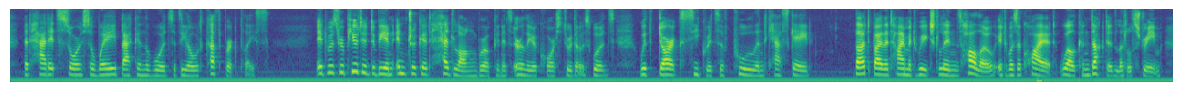

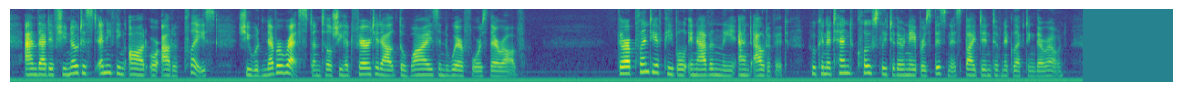

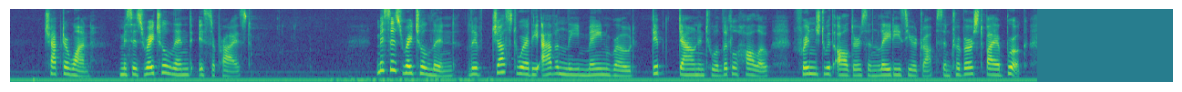

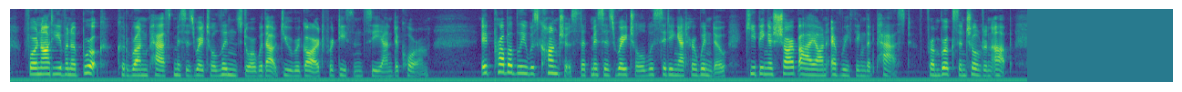

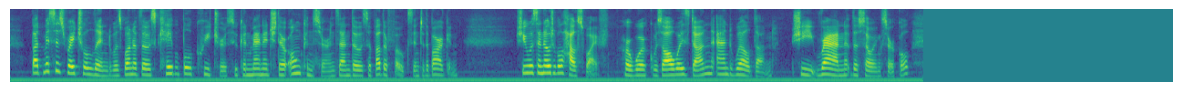

In [5]:
for samp in batch["input_values"]:
    
    ### Visualize (And Flip so Low frequencies are at the bottom) ###
    plt.figure(figsize=(15,5))
    plt.imshow(samp.squeeze())
    plt.axis("off")
    plt.gca().invert_yaxis()
    plt.show()


Notice that padding at the end? Pad tokens are just there to fill the matrix, they shouldn't take part in the computation or gradients so we have to do two things. 

### Adjust for Convolution Downsample
Remember, when we do convolutions, our signal can get downsampled. For example, if we have a ```(256 x 256)``` image and we convolve it with a stride of 2, we should get a roughly ```(128 x 128)``` image! Now in our case, we have a batch of ```(80 x 1276)``` image, but not all those pixels are valid in every sample, some are padding. This means after we convolve our signal and downsample by some factor, we need to also compute which of the downsampled pixels came from padding and which didnt! Luckily for us we have a formula for this, we know exactly what the output shape of a convolution is given the input!

You can see this in the [Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) docs from PyTorch!

$$O = \lfloor \frac{I + (2 * \text{padding }) - \text{dilation} * (\text{kernel\_size} - 1) - 1}{stride}  + 1  \rfloor$$

This means, lets say I pass in my spectrogram with length of ```1276```, but I know only the first ```1002``` of those timesteps are valid! Lets say we do a convolution with kernel size 3 and stride of 2 with no padding:

**Note** 

Our Convolution is 2d (its an image) so we will have a convolution in both the time dimension but also the feature (mel bins) dimension. We are not caring too much about the mel bins dimension right now as that is always 80, its the time dimension that can change. This means when we write things like our kernel size of ```(3,3)```, it is a kernel size of 3 in the mel dimension and a kernel size of 3 in the time dimension. Similarly, if we write our convolution stride as ```(1,2)```, we will have as stride of 1 along the mel dimension, and then a stride of 2 along the time dimension.

For now lets just care about the time dimension

In [6]:
conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(3,3), stride=(1,2), padding=(1,0))

output = conv(batch["input_values"])

print("Output Shape:", output.shape)

Output Shape: torch.Size([5, 1, 80, 637])


So we have downsampled out total batch length from ```1276``` down to ```637```! But in that original ```1276```, some of those timestamps were padding, so the question is, after we downsample, what parts of the downsampled signal came from padding, and what parts came from non-padding? Well we have the sequence lengths of the original data, so lets see what the shapes of those sequence lengths are after we apply convolution with our formula:

In [7]:
padding = 0
kernel_size = 3
stride = 2

print("Input Seq Lens:", batch["seq_lens"])

output_seq_lens = torch.floor((batch["seq_lens"] + (2 * padding) - (kernel_size - 1) - 1) // stride + 1)

print("Output Seq Lens:", output_seq_lens)

Input Seq Lens: tensor([1276, 1177, 1127, 1116, 1002])
Output Seq Lens: tensor([637, 588, 563, 557, 500])


Now we have what we wanted! So the output shape we had earlier was ```(5 x 1 x 80 x 637)```, and our data was presorted from longest to shortest. So that means the longest sample (the first one in the batch) had no padding.

Notice the output sequence length of the first sample: The full ```637```! This makes sense as there was no padding so the entire convolution output is valid. 

Lets check the last one now. The last sample in the batch (the shortest) started with a length of ```1002``` and was padded to the ```1276``` of the longest sample. The output of convolving the ```1002``` length signal with our convolution above would have given a final length of ```500```. This means of the total ```637``` output in the batch, only the first ```500``` timesteps are valid, everything else came from the padding! 

### Masking the Output

We now know the output sequence length of every spectrogram, meaning any sequence length after those are not valid. We must remask them to 0 to be as accurate as possible! This is pretty easy, we can just create a new ```[0,1]``` mask based on the output sequence lengths and multiply our data by it, zeroing out any non-valid convolution output coming from the padding regions. 

In [8]:
### Create a Mask ###
mask = torch.nn.utils.rnn.pad_sequence([torch.ones(i) for i in output_seq_lens], padding_value=0, batch_first=True)

### Multiply out Output by the Mask (add in extra dimensions for channels and mel dimension) ###

print("Shortest Sample Without Mask")
print(output[-1], "\n")

output = output * mask.unsqueeze(1).unsqueeze(1)

print("Shortest Sample With Mask")
print(output[-1], "\n")

Shortest Sample Without Mask
tensor([[[-0.6769, -0.6472, -0.6468,  ..., -0.0071, -0.0071, -0.0071],
         [-1.2741, -1.0400, -1.0682,  ..., -0.0071, -0.0071, -0.0071],
         [-1.2996, -1.0854, -1.1275,  ..., -0.0071, -0.0071, -0.0071],
         ...,
         [ 0.9789,  1.1541,  1.2237,  ..., -0.0071, -0.0071, -0.0071],
         [ 0.9146,  1.1539,  1.1788,  ..., -0.0071, -0.0071, -0.0071],
         [ 0.7863,  0.8547,  0.8822,  ..., -0.0071, -0.0071, -0.0071]]],
       grad_fn=<SelectBackward0>) 

Shortest Sample With Mask
tensor([[[-0.6769, -0.6472, -0.6468,  ..., -0.0000, -0.0000, -0.0000],
         [-1.2741, -1.0400, -1.0682,  ..., -0.0000, -0.0000, -0.0000],
         [-1.2996, -1.0854, -1.1275,  ..., -0.0000, -0.0000, -0.0000],
         ...,
         [ 0.9789,  1.1541,  1.2237,  ..., -0.0000, -0.0000, -0.0000],
         [ 0.9146,  1.1539,  1.1788,  ..., -0.0000, -0.0000, -0.0000],
         [ 0.7863,  0.8547,  0.8822,  ..., -0.0000, -0.0000, -0.0000]]],
       grad_fn=<SelectBac

And we have finally masked out final spectrogram! Lets go ahead and put it all together!

### Create the Masked Conv2d ###

In [9]:
class MaskedConv2d(nn.Conv2d):

    """
    Our spectrograms are padded, so different spectrograms will have 
    a different length. We need to make sure we dont include any padding information
    in our convolution, and update padding masks for the next convolution in the stack!

    Args:
        
    """

    def __init__(self, 
                 in_channels,
                 out_channels, 
                 kernel_size,
                 stride, 
                 padding=0,
                 bias=True,
                 **kwargs):
        
        super(MaskedConv2d, self).__init__(in_channels=in_channels, 
                                           out_channels=out_channels, 
                                           kernel_size=kernel_size, 
                                           stride=stride, 
                                           padding=padding, 
                                           bias=bias, 
                                           **kwargs)

    def forward(self, x, seq_lens):

        """
        Updates convolution forward to zero out padding regions after convolution 
        """

        batch_size, channels, height, width = x.shape
        
        ### Compute Output Seq Lengths of Each Sample After Convolution ###
        output_seq_lens = self._compute_output_seq_len(seq_lens)

        ### Pass Data Through Convolution ###
        conv_out = super().forward(x)

        ### Zero Out Any Values In The Padding Region (After Convolution) So they Dont Contribute ###
        mask = torch.zeros(batch_size, output_seq_lens.max(), device=x.device)
        for i, length in enumerate(output_seq_lens):
            mask[i, :length] = 1

        ### Unsqueeze mask to match image shape ###
        mask = mask.unsqueeze(1).unsqueeze(1)

        ### Apply Mask ###
        conv_out = conv_out * mask

        return conv_out, output_seq_lens

    def _compute_output_seq_len(self, seq_lens):

        """
        To perform masking AFTER the encoding 2D Convolutions, we need to 
        compute what the shape of the output tensor is after each successive convolutions
        is applied.
    
        Convolution formula can be found in PyTorch Docs: https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html
            
        """
        
        return torch.floor((seq_lens + (2 * self.padding[1]) - (self.kernel_size[1] - 1) - 1) // self.stride[1]) + 1


### Convolutional Feature Extractor

Create a stack of two convolutions (following the [Nvidia Implementation](https://nvidia.github.io/OpenSeq2Seq/html/speech-recognition/deepspeech2.html) details), with ```BatchNorm2d``` and the ```HardTanh``` Activation function

The output of the convolutions will give the shape ```(Batch x Channels x Mel_Features x Time)```. To give this to the future RNN, we need to reshape it to ```(Batch x Time x Channels*Mel_Features)```

This convolution feature extractor should also return the output sequence lengths so we know what the final valid non-padding regions are after all the convolutions are done!

In [10]:
class ConvolutionFeatureExtractor(nn.Module):

    def __init__(self, 
                 in_channels=1, 
                 out_channels=32):

        super(ConvolutionFeatureExtractor, self).__init__()

        self.in_channels = in_channels, 
        self.out_channels = out_channels

        self.conv1 = MaskedConv2d(in_channels, out_channels, kernel_size=(11, 41), stride=(2,2), padding=(5,20), bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = MaskedConv2d(out_channels, out_channels, kernel_size=(11, 21), stride=(2,1), padding=(5,10), bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        ### I just preset this, I know after I apply my two convolutions above with a kernel size of 
        ### 11, that my output feature vectors will go from 80 down to 20! I could also dynamically
        ### compute this but its probably fine, I wont be changing the data after all!
        self.output_feature_dim = 20

        ### Compute Final Output Features ###
        self.conv_output_features = self.output_feature_dim * self.out_channels
        
    def forward(self, x, seq_lens):

        x, seq_lens = self.conv1(x, seq_lens)
        x = self.bn1(x)
        x = torch.nn.functional.hardtanh(x)
        
        x, seq_lens = self.conv2(x, seq_lens)
        x = self.bn2(x)
        x = torch.nn.functional.hardtanh(x)
        
        x = x.permute(0,3,1,2).flatten(2)

        return x, seq_lens 


### RNN Layer

Now that we have our convolution features extracted, time to pass them to the RNN to learn the sequence information! This is a Bidirectional RNN (can look both ways) and we will do it on a packed sequence (that removes the padding tokens)

#### Packed Padding

In [11]:
conv = ConvolutionFeatureExtractor()

conv_out, out_seq_lens = conv(batch["input_values"], batch["seq_lens"])

print("Convolution Output:", conv_out.shape)
print("Valid Seq Lens:", out_seq_lens)

### Pack the Convolution Output on Valid Timesteps ###
packed_conv_out = nn.utils.rnn.pack_padded_sequence(conv_out, out_seq_lens, batch_first=True)

print("Packed Output")
print(packed_conv_out)


Convolution Output: torch.Size([5, 638, 640])
Valid Seq Lens: tensor([638, 589, 564, 558, 501])
Packed Output
PackedSequence(data=tensor([[-0.3497,  0.6943,  0.3230,  ..., -0.6326, -0.4721, -0.2939],
        [-0.1910,  0.4113,  1.0000,  ..., -0.2650,  0.0612, -0.4251],
        [-0.1034,  0.6164, -0.8797,  ..., -0.1061, -0.3533,  0.0276],
        ...,
        [-0.4232, -1.0000,  0.2162,  ..., -0.7979, -0.5810,  0.1710],
        [-0.7428, -0.8690,  0.0961,  ..., -0.7778, -0.5967,  0.3146],
        [-0.4270, -0.1345,  0.0061,  ..., -0.7892, -0.9942,  0.1161]],
       grad_fn=<PackPaddedSequenceBackward0>), batch_sizes=tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5

In [12]:
class RNNLayer(nn.Module):

    def __init__(self, 
                 input_size,
                 hidden_size = 512):

        super(RNNLayer, self).__init__()

        self.hidden_dim = hidden_size
        self.input_size = input_size

        self.rnn = nn.LSTM(
            input_size=input_size, 
            hidden_size=hidden_size, 
            batch_first=True, 
            bidirectional=True,
        )

        self.layernorm = nn.LayerNorm(2 * hidden_size)

    def forward(self, x, seq_lens):

        batch, seq_len, embed_dim = x.shape 
        
        ### Pack Sequence (For efficient computation that ignores padding) ###
        packed_x = nn.utils.rnn.pack_padded_sequence(x, seq_lens, batch_first=True)

        ### Pass Packed Sequence through RNN ###
        out, _ = self.rnn(packed_x)

        ### Unpack (and repad) sequence ###
        x, _ = nn.utils.rnn.pad_packed_sequence(out, total_length=seq_len, batch_first=True)

        ### Normalize ###
        x = self.layernorm(x)

        return x
        

### Put it Together

Now we just put it all together to create our DeepSpeed2 model!

In [13]:
class DeepSpeech2(nn.Module):

    def __init__(self,
                 conv_in_channels=1, 
                 conv_out_channels=32, 
                 rnn_hidden_size=512,
                 rnn_depth=5):

        super(DeepSpeech2, self).__init__()

        self.feature_extractor = ConvolutionFeatureExtractor(
            conv_in_channels, conv_out_channels
        )

        self.output_hidden_features = self.feature_extractor.conv_output_features

        ### Stack Together RNN Layers ###
        ### First Layer has 640 inputs, everything after has 2 * 512 inputs ###
        self.rnns = nn.ModuleList(
            [
                RNNLayer(input_size=self.output_hidden_features if i==0 else 2 * rnn_hidden_size,
                         hidden_size=rnn_hidden_size)
                for i in range(rnn_depth)
            ]
        )

        ### Classification Head ###
        self.head = nn.Sequential(
            nn.Linear(2 * rnn_hidden_size, rnn_hidden_size), 
            nn.Hardtanh(), 
            nn.Linear(rnn_hidden_size, tokenizer.vocab_size)
        )

    def forward(self, x, seq_lens):

        ### Extract Features ###
        x, final_seq_lens = self.feature_extractor(x, seq_lens)

        ### Pass To RNN Layers ###
        for rnn in self.rnns:
            x = rnn(x, final_seq_lens)

        ### Classification Head ###
        x = self.head(x)

        return x, final_seq_lens  

### Training Script

In [14]:
### TRAINING ARGUMENTS ###
BATCH_SIZE = 32
TRAINING_ITERATIONS = 50000
EVAL_ITERATIONS = 2500
LEARNING_RATE = 1e-4
NUM_WORKERS = 32
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

### DATALOADERS ###
DATASET_ROOT = "/mnt/datadrive/data/LibriSpeech"
trainset = LibriSpeechDataset(path_to_data_root=DATASET_ROOT, include_splits=["train-clean-100", "train-clean-360", "train-other-500"])
testset =  LibriSpeechDataset(path_to_data_root=DATASET_ROOT, include_splits=["test-clean", "dev-clean"])
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn, num_workers=NUM_WORKERS)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn, num_workers=NUM_WORKERS)

### DEFINE MODEL ###
model = DeepSpeech2(conv_in_channels=1, 
                    conv_out_channels=32, 
                    rnn_hidden_size=512).to(DEVICE)

params = sum([p.numel() for p in model.parameters()])
print("Total Training Parameters:", params)

### OPTIMIZER/SCHEDULER ###
optimizer = optim.AdamW(params=model.parameters(), lr=LEARNING_RATE)
scheduler = get_cosine_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=500, 
                                            num_training_steps=TRAINING_ITERATIONS)


Total Training Parameters: 30727936


In [15]:
### HOUSEKEEPING ###
best_val_loss = np.inf 
train = True
completed_steps = 0
train_loss, validation_loss = [], []
pbar = tqdm(range(TRAINING_ITERATIONS))

### TRAINING LOOP ###
while train:

    training_losses = []
    validation_losses = []
    
    for batch in trainloader:
        
        ### Pass Through Model and get input_lengths (post convolutions) and logits ###
        logits, input_lengths = model(x=batch["input_values"].to(DEVICE), 
                                      seq_lens=batch["seq_lens"])

        ### CTC Expects Log Probabilities ###
        log_probs = nn.functional.log_softmax(logits, dim=-1)

        ### CTC Also Expects (T x B x C), we have (B x T x C) ###
        log_probs = log_probs.transpose(0,1)

        ### Compute CTC Loss ###
        loss = nn.functional.ctc_loss(
            log_probs=log_probs,
            targets=batch["labels"].to(DEVICE),
            input_lengths=input_lengths, 
            target_lengths=batch["target_lengths"], 
            blank=tokenizer.pad_token_id, 
            reduction="mean", 
        )

        ### Update Model ###
        loss.backward()
        optimizer.step()
        optimizer.zero_grad(set_to_none=True)
        scheduler.step()

        ### Store Loss ###
        training_losses.append(loss.item())

        ### Iterate Counter ###
        completed_steps += 1
        pbar.update(1)

        if completed_steps % EVAL_ITERATIONS == 0:

            print("Evaluating")
    
            model.eval()
            
            for batch in tqdm(testloader):
                
                ### Pass Through Model and get input_lengths (post convolutions) and logits ###
                with torch.no_grad():
                    logits, input_lengths = model(x=batch["input_values"].to(DEVICE), 
                                                  seq_lens=batch["seq_lens"])
        
                ### CTC Expects Log Probabilities ###
                log_probs = nn.functional.log_softmax(logits, dim=-1)
        
                ### CTC Also Expects (T x B x C), we have (B x T x C) ###
                log_probs = log_probs.transpose(0,1)
        
                ### Compute CTC Loss ###
                loss = nn.functional.ctc_loss(
                    log_probs=log_probs,
                    targets=batch["labels"].to(DEVICE),
                    input_lengths=input_lengths, 
                    target_lengths=batch["target_lengths"], 
                    blank=tokenizer.pad_token_id, 
                    reduction="mean", 
                )
        
                ### Store Loss ###
                validation_losses.append(loss.item())
                
            training_loss_mean = np.mean(training_losses)
            valid_loss_mean = np.mean(validation_losses)
        
            train_loss.append(training_loss_mean)
            validation_loss.append(valid_loss_mean)

            ### Save Model If Val Loss Decreases ###
            if valid_loss_mean < best_val_loss:
                print("---Saving Model---")
                torch.save(model.state_dict(), "best_weights.pt")
                best_val_loss = valid_loss_mean

            print("Training Loss:", training_loss_mean)
            print("Validation Loss:", valid_loss_mean)

            ### Reset Lists for Store ###
            training_losses = []
            validation_losses = []

            ### Set Model to Training Mode ###
            model.train()

        if completed_steps >= TRAINING_ITERATIONS:
            train = False
            print("Completed Training")
            break


  0%|          | 0/50000 [00:00<?, ?it/s]

Evaluating


  0%|          | 0/167 [00:00<?, ?it/s]

---Saving Model---
Training Loss: 1.567255725121498
Validation Loss: 0.8201563643838117
Evaluating


  0%|          | 0/167 [00:00<?, ?it/s]

---Saving Model---
Training Loss: 0.7711260512590409
Validation Loss: 0.5523256313301133
Evaluating


  0%|          | 0/167 [00:00<?, ?it/s]

---Saving Model---
Training Loss: 0.5901196722865105
Validation Loss: 0.43321139673273007
Evaluating


  0%|          | 0/167 [00:00<?, ?it/s]

---Saving Model---
Training Loss: 0.44853344889439206
Validation Loss: 0.3636389440762069
Evaluating


  0%|          | 0/167 [00:00<?, ?it/s]

---Saving Model---
Training Loss: 0.4135821423768997
Validation Loss: 0.3224263319712199
Evaluating


  0%|          | 0/167 [00:00<?, ?it/s]

---Saving Model---
Training Loss: 0.3769014673411846
Validation Loss: 0.2909811756568041
Evaluating


  0%|          | 0/167 [00:00<?, ?it/s]

---Saving Model---
Training Loss: 0.34534698950648307
Validation Loss: 0.26881744315524303
Evaluating


  0%|          | 0/167 [00:00<?, ?it/s]

---Saving Model---
Training Loss: 0.2837829084053303
Validation Loss: 0.2474238896619774
Evaluating


  0%|          | 0/167 [00:00<?, ?it/s]

---Saving Model---
Training Loss: 0.2720911774456501
Validation Loss: 0.23412749394328294
Evaluating


  0%|          | 0/167 [00:00<?, ?it/s]

---Saving Model---
Training Loss: 0.26048978043198584
Validation Loss: 0.22264335255422993
Evaluating


  0%|          | 0/167 [00:00<?, ?it/s]

---Saving Model---
Training Loss: 0.2080671500680937
Validation Loss: 0.21322516838233627
Evaluating


  0%|          | 0/167 [00:00<?, ?it/s]

---Saving Model---
Training Loss: 0.2053336164534092
Validation Loss: 0.20776621042611357
Evaluating


  0%|          | 0/167 [00:00<?, ?it/s]

---Saving Model---
Training Loss: 0.20051361669301987
Validation Loss: 0.20155884254121495
Evaluating


  0%|          | 0/167 [00:00<?, ?it/s]

---Saving Model---
Training Loss: 0.19565960410833358
Validation Loss: 0.1963692488159962
Evaluating


  0%|          | 0/167 [00:00<?, ?it/s]

---Saving Model---
Training Loss: 0.16237847674193032
Validation Loss: 0.19611635322342374
Evaluating


  0%|          | 0/167 [00:00<?, ?it/s]

---Saving Model---
Training Loss: 0.16168750965595247
Validation Loss: 0.19300754908137693
Evaluating


  0%|          | 0/167 [00:00<?, ?it/s]

---Saving Model---
Training Loss: 0.15900251406133176
Validation Loss: 0.19165539424754902
Evaluating


  0%|          | 0/167 [00:00<?, ?it/s]

---Saving Model---
Training Loss: 0.14196230415343108
Validation Loss: 0.19129110903975494
Evaluating


  0%|          | 0/167 [00:00<?, ?it/s]

---Saving Model---
Training Loss: 0.1433017353594303
Validation Loss: 0.19110034000195428
Evaluating


  0%|          | 0/167 [00:00<?, ?it/s]

Training Loss: 0.143725186753273
Validation Loss: 0.1912668934928443
Completed Training


### Training Results

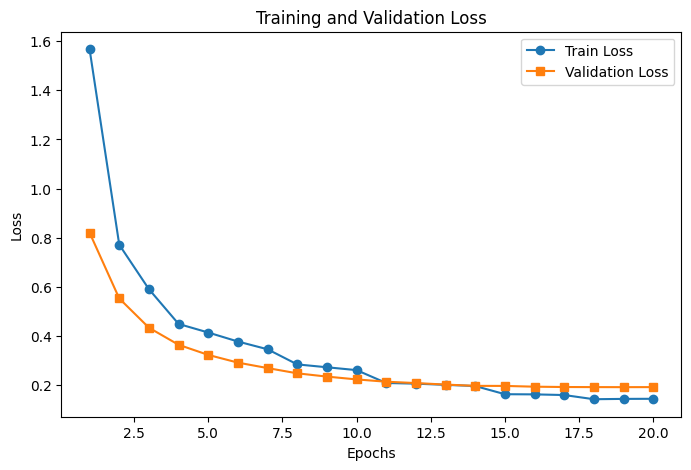

In [16]:
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_loss, label="Train Loss", marker='o')
plt.plot(epochs, validation_loss, label="Validation Loss", marker='s')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

### Load Best Checkpoint

In [17]:
model = DeepSpeech2()
model.load_state_dict(torch.load("best_weights.pt", weights_only=True))

<All keys matched successfully>

### Inference Audio 

Lets write a quick function that can take the path to an audio and transcribe it

#### Word Error Rate

A common metric to evaluate ASR models is Word Error Rate. There is a great packaged called ```jiwer``` that makes this easy!

In [18]:
def inference(path_to_audio, model, tokenizer, sampling_rate=16000, device="cpu"):

    ### Transforms ###
    audio2mels =  T.MelSpectrogram(
            sample_rate=sampling_rate,
            n_mels=80
        )
    amp2db = T.AmplitudeToDB(
        top_db=80.0
    )

    ### Convert Audio to Mels ###
    audio, orig_sr = torchaudio.load(path_to_audio, normalize=True)
    if orig_sr != sampling_rate:
        audio = torchaudio.functional.resample(audio, orig_freq=orig_sr, new_freq=sampling_rate)
    mel = audio2mels(audio)
    mel = amp2db(mel)
    mel = (mel - mel.mean()) / (mel.std() + 1e-6)
        
    ### Add in Batch Dimension ###
    mel = mel.unsqueeze(0)

    ### Compute src_len ###
    src_len = torch.tensor([mel.shape[-1]])

    ### Set Model Device ###
    model = model.to(device)
    
    ### Inference Model ###
    with torch.no_grad():
        pred_logits, _ = model(mel.to(device), src_len)

    ### Greedy Decode ###
    pred_tokens = pred_logits.squeeze().argmax(axis=-1).tolist()

    ### Prediction ###
    pred_transcript = tokenizer.decode(pred_tokens)

    return pred_transcript
    
### Grab a Random Sample from the Test Set ###
path_to_sample, transcript = testset.librispeech_data[0]

### Predict Transcript ###
pred_transcript = inference(path_to_sample, model, tokenizer)

print("Ground Truth:")
print(transcript, "\n")

print("Prediction:")
print(pred_transcript, "\n")

error = wer(transcript, pred_transcript)
print("Word Error Rate:")
print(error)

Ground Truth:
HE HOPED THERE WOULD BE STEW FOR DINNER TURNIPS AND CARROTS AND BRUISED POTATOES AND FAT MUTTON PIECES TO BE LADLED OUT IN THICK PEPPERED FLOUR FATTENED SAUCE 

Prediction:
HE HOPED THERE WOULD BE STO FOR DINNER TURNIPS OND CAROTS AND BRUISED POTATOES AND FAT MUTDON PIECES TO BE LADLED OUT IN THICK PEPPERED FLOWER FATEND SAUCE 

Word Error Rate:
0.21428571428571427


### Overall WER

In [19]:
errors = []
for path_to_sample, transcript in tqdm(testset.librispeech_data):

    ### Predict Transcript ###
    pred_transcript = inference(path_to_sample, model, tokenizer, device="cuda")

    errors.append(wer(transcript, pred_transcript))

print("Overall Error")
print(np.mean(errors))

  0%|          | 0/5323 [00:00<?, ?it/s]

Overall Error
0.18419178909992104


### Thats It!

We created a reasonable transcription model here today! The word error rate is a little high (as our model is getting the words mostly correct but misspelling them), but this should give you the intuition for how ASR models work! All we need to do now is replace the LSTM with a Transformer and we can start implementing SOTA models soon!